In [6]:
%matplotlib inline


from dmp import DMPs
import numpy as np

In [16]:
class DMPs_discrete(DMPs):
    """An implementation of discrete DMPs"""

    def __init__(self, **kwargs):
        """
        """

        # call super class constructor
        super(DMPs_discrete, self).__init__(pattern='discrete', **kwargs)

        self.gen_centers()

        # set variance of Gaussian basis functions
        # trial and error to find this spacing
        self.h = np.ones(self.n_bfs) * self.n_bfs**1.5 / self.c / self.cs.ax

        self.check_offset()

    def gen_centers(self):
        """Set the centre of the Gaussian basis
        functions be spaced evenly throughout run time"""

        '''x_track = self.cs.discrete_rollout()
        t = np.arange(len(x_track))*self.dt
        # choose the points in time we'd like centers to be at
        c_des = np.linspace(0, self.cs.run_time, self.n_bfs)
        self.c = np.zeros(len(c_des))
        for ii, point in enumerate(c_des):
            diff = abs(t - point)
            self.c[ii] = x_track[np.where(diff == min(diff))[0][0]]'''

        # desired activations throughout time
        des_c = np.linspace(0, self.cs.run_time, self.n_bfs)

        self.c = np.ones(len(des_c))
        for n in range(len(des_c)):
            # finding x for desired times t
            self.c[n] = np.exp(-self.cs.ax * des_c[n])
        
        print(self.c)

    def gen_front_term(self, x, dmp_num):
        """Generates the diminishing front term on
        the forcing term.

        x float: the current value of the canonical system
        dmp_num int: the index of the current dmp
        """
        return x * (self.goal[dmp_num] - self.y0[dmp_num])

    def gen_goal(self, y_des):
        """Generate the goal for path imitation.
        For rhythmic DMPs the goal is the average of the
        desired trajectory.

        y_des np.array: the desired trajectory to follow
        """

        return np.copy(y_des[:, -1])

    def gen_psi(self, x):
        """Generates the activity of the basis functions for a given
        canonical system rollout.

        x float, array: the canonical system state or path
        """

        if isinstance(x, np.ndarray):
            x = x[:, None]
        return np.exp(-self.h * (x - self.c)**2)

    def gen_weights(self, f_target):
        """Generate a set of weights over the basis functions such
        that the target forcing term trajectory is matched.

        f_target np.array: the desired forcing term trajectory
        """

        # calculate x and psi
        x_track = self.cs.rollout()
        psi_track = self.gen_psi(x_track)

        # efficiently calculate BF weights using weighted linear regression
        self.w = np.zeros((self.n_dmps, self.n_bfs))
        for d in range(self.n_dmps):
            # spatial scaling term
            k = (self.goal[d] - self.y0[d])
            for b in range(self.n_bfs):
                numer = np.sum(x_track * psi_track[:, b] * f_target[:, d])
                denom = np.sum(x_track**2 * psi_track[:, b])
                self.w[d, b] = numer / (k * denom)
        self.w = np.nan_to_num(self.w)

[1.         0.89483932 0.8007374  0.71653131 0.64118039 0.57375342
 0.51341712 0.45942582 0.41111229 0.36787944]
[1.         0.89483932 0.8007374  0.71653131 0.64118039 0.57375342
 0.51341712 0.45942582 0.41111229 0.36787944]
[1.         0.966105   0.93335886 0.90172266 0.87115877 0.84163084
 0.81310376 0.78554361 0.7589176  0.73319409 0.70834247 0.6843332
 0.66113772 0.63872846 0.61707876 0.59616287 0.57595593 0.5564339
 0.53757357 0.51935251 0.50174906 0.48474227 0.46831193 0.45243849
 0.43710309 0.42228748 0.40797404 0.39414576 0.38078619 0.36787944]
[1.         0.97979867 0.96000544 0.94061206 0.92161045 0.90299269
 0.88475104 0.8668779  0.84936582 0.8322075  0.81539581 0.79892373
 0.78278441 0.76697113 0.75147729 0.73629646 0.72142229 0.7068486
 0.69256932 0.67857851 0.66487032 0.65143906 0.63827912 0.62538504
 0.61275143 0.60037304 0.58824471 0.57636139 0.56471812 0.55331007
 0.54213247 0.53118068 0.52045012 0.50993634 0.49963495 0.48954166
 0.47965227 0.46996266 0.46046879 0.451

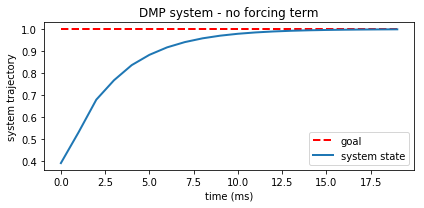

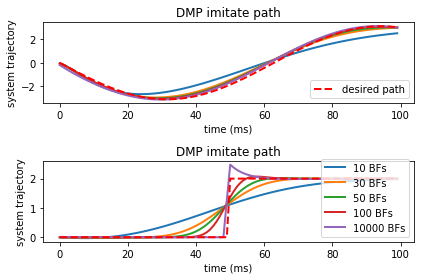

In [17]:
import matplotlib.pyplot as plt

# test normal run
dmp = DMPs_discrete(dt=.05, n_dmps=1, n_bfs=10, w=np.zeros((1, 10)))
y_track, dy_track, ddy_track = dmp.rollout()

plt.figure(1, figsize=(6, 3))
plt.plot(np.ones(len(y_track))*dmp.goal, 'r--', lw=2)
plt.plot(y_track, lw=2)
plt.title('DMP system - no forcing term')
plt.xlabel('time (ms)')
plt.ylabel('system trajectory')
plt.legend(['goal', 'system state'], loc='lower right')
plt.tight_layout()

# test imitation of path run
plt.figure(2, figsize=(6, 4))
n_bfs = [10, 30, 50, 100, 10000]

# a straight line to target
path1 = np.sin(np.arange(0, 1, .01)*5)
# a strange path to target
path2 = np.zeros(path1.shape)
path2[int(len(path2) / 2.):] = .5

for ii, bfs in enumerate(n_bfs):
    dmp = DMPs_discrete(n_dmps=2, n_bfs=bfs)

    dmp.imitate_path(y_des=np.array([path1, path2]))
    # change the scale of the movement
    dmp.goal[0] = 3
    dmp.goal[1] = 2

    y_track, dy_track, ddy_track = dmp.rollout()

    plt.figure(2)
    plt.subplot(211)
    plt.plot(y_track[:, 0], lw=2)
    plt.subplot(212)
    plt.plot(y_track[:, 1], lw=2)

plt.subplot(211)
a = plt.plot(path1 / path1[-1] * dmp.goal[0], 'r--', lw=2)
plt.title('DMP imitate path')
plt.xlabel('time (ms)')
plt.ylabel('system trajectory')
plt.legend([a[0]], ['desired path'], loc='lower right')
plt.subplot(212)
b = plt.plot(path2 / path2[-1] * dmp.goal[1], 'r--', lw=2)
plt.title('DMP imitate path')
plt.xlabel('time (ms)')
plt.ylabel('system trajectory')
plt.legend(['%i BFs' % i for i in n_bfs], loc='lower right')

plt.tight_layout()
plt.show()
